In [1]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from nlp_project.notebook_utils import compact_split, evaluate
import evaluate as ev

In [2]:
# Various functions
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

def report(trainer, test_set, labels, model_name=None):
    preds = trainer.predict(test_set)
    y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
    
    if model_name is not None:
        print(model_name)
    
    evaluate(test_set['label'], y_pred, labels)
    

def import_model(model_name, labels, device):
    transformer = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(labels)
    )
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    transformer = transformer.to(device)
    
    return transformer, tokenizer

    
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding='max_length', 
                     truncation=True, 
                     max_length=max_length)
    

def clean_gpu_memory(transformer, tokenizer):
    del transformer
    del tokenizer
    torch.cuda.empty_cache()

@torch.no_grad()
def predict(text, labels):
    input_encodings = tokenizer(text, return_tensors='pt').to(device)
    outputs = bert(**input_encodings)
    
    lbl = labels[torch.argmax(outputs.logits).item()]

    return lbl

In [3]:
# Seed for reproducibility
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise SystemError('GPU device not found')

In [4]:
# Import main dataset
df = pd.read_csv("../../AUTEXTIFICATION/subtask_2/train.tsv", sep="\t")
df = df.drop("id", axis=1)
df['label'] = df['label'].replace({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5})

labels = ["A", "B", "C", "D", "E", "F"]
max_length = 135

df

,text,label
0,It was not until many years later that it coul...,0
1,Users can then pin these images to their profi...,5
2,The best songs are those that I can sing along...,1
3,I found this book to be poorly written. It was...,3
4,Regulates the application of the EU tariff quo...,4
...,...,...
22411,The ministry had earlier said it was working w...,1
22412,"Once combined, slowly add the melted butter, s...",5
22413,Hightower for this new and wellwritten book!. ...,1
22414,All throughout the whole book this author has ...,3


In [5]:
train, val, test = compact_split(df, test_size=0.1, val_size=0.1, seed=seed)

data = DatasetDict()
data['train'] = Dataset.from_pandas(train)
data['validation'] = Dataset.from_pandas(val)
data['test'] = Dataset.from_pandas(test)

metric = ev.load("accuracy")

In [8]:
model_name = 'bert-base-multilingual-uncased'

transformer, tokenizer = import_model(model_name, labels, device)
tokenized_data = data.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir=f'models/{model_name}',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0,
    num_train_epochs=3,
    logging_steps=100,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_total_limit=2,
    save_steps=100,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=transformer, 
    args=training_args, 
    train_dataset=tokenized_data['train'], 
    eval_dataset=tokenized_data['validation'],
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

Map:   0%|          | 0/17932 [00:00<?, ? examples/s]

Map:   0%|          | 0/2242 [00:00<?, ? examples/s]

Map:   0%|          | 0/2242 [00:00<?, ? examples/s]

/home/crimsowl/.cache/pypoetry/virtualenvs/nlp-project-7TuoKFiO-py3.11/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,1.564800,1.305628,0.438002
200,1.260900,1.189953,0.483497
300,1.157100,1.075996,0.515165
400,1.111500,1.098540,0.483497
500,1.066100,1.070605,0.511597
600,0.968200,1.069000,0.514719
700,0.914200,0.995775,0.541481
800,0.889400,0.993047,0.569581
900,0.888500,0.993682,0.546387
1000,0.865500,0.986101,0.556646


bert-base-multilingual-uncased
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       350
           1       0.52      0.54      0.53       382
           2       0.50      0.54      0.52       394
           3       0.50      0.52      0.51       381
           4       0.38      0.25      0.30       366
           5       0.68      0.89      0.77       369

    accuracy                           0.57      2242
   macro avg       0.56      0.57      0.56      2242
weighted avg       0.56      0.57      0.56      2242



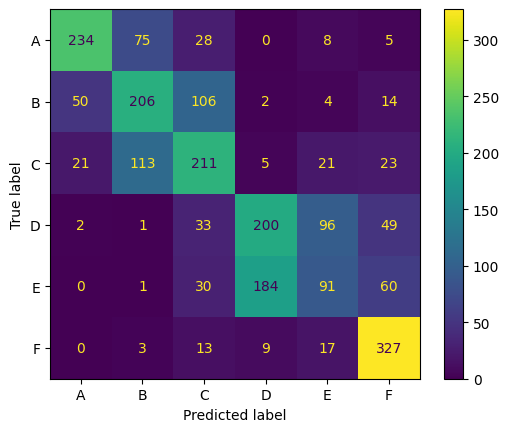

In [9]:
trainer.train()
report(trainer, tokenized_data['test'], labels, model_name)

In [10]:
clean_gpu_memory(transformer, tokenizer)

In [11]:
model_name = 'bert-base-multilingual-cased'

transformer, tokenizer = import_model(model_name, labels, device)
tokenized_data = data.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir=f'models/{model_name}',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0,
    num_train_epochs=3,
    logging_steps=100,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_total_limit=2,
    save_steps=100,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=transformer, 
    args=training_args, 
    train_dataset=tokenized_data['train'], 
    eval_dataset=tokenized_data['validation'],
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Map:   0%|          | 0/17932 [00:00<?, ? examples/s]

Map:   0%|          | 0/2242 [00:00<?, ? examples/s]

Map:   0%|          | 0/2242 [00:00<?, ? examples/s]

/home/crimsowl/.cache/pypoetry/virtualenvs/nlp-project-7TuoKFiO-py3.11/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,1.625100,1.363232,0.405888
200,1.334600,1.167418,0.491525
300,1.162900,1.047176,0.528992
400,1.112600,1.092206,0.521855
500,1.082600,1.027175,0.532560
600,1.014000,1.063108,0.520071
700,0.930500,0.989081,0.553970
800,0.929600,0.986038,0.557092
900,0.902000,0.985515,0.532114
1000,0.883400,1.033419,0.542373


bert-base-multilingual-cased
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       350
           1       0.52      0.51      0.52       382
           2       0.51      0.59      0.55       394
           3       0.50      0.43      0.47       381
           4       0.46      0.39      0.42       366
           5       0.72      0.89      0.80       369

    accuracy                           0.58      2242
   macro avg       0.58      0.58      0.58      2242
weighted avg       0.57      0.58      0.57      2242



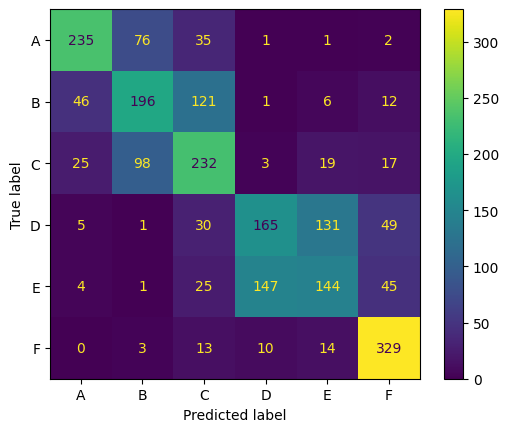

In [12]:
trainer.train()
report(trainer, tokenized_data['test'], labels, model_name)

In [14]:
model_name = 'distilbert-base-multilingual-cased'

transformer, tokenizer = import_model(model_name, labels, device)
tokenized_data = data.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir=f'models/{model_name}',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0,
    num_train_epochs=3,
    logging_steps=100,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_total_limit=2,
    save_steps=100,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=transformer, 
    args=training_args, 
    train_dataset=tokenized_data['train'], 
    eval_dataset=tokenized_data['validation'],
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.weight', 'classif

Map:   0%|          | 0/17932 [00:00<?, ? examples/s]

Map:   0%|          | 0/2242 [00:00<?, ? examples/s]

Map:   0%|          | 0/2242 [00:00<?, ? examples/s]

/home/crimsowl/.cache/pypoetry/virtualenvs/nlp-project-7TuoKFiO-py3.11/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,1.600600,1.533633,0.347458
200,1.242400,1.138040,0.481713
300,1.133000,1.059227,0.520517
400,1.109100,1.100038,0.488849
500,1.083000,1.001283,0.553078
600,0.972700,1.037446,0.524086
700,0.916000,0.954947,0.554862
800,0.915000,0.979174,0.553524
900,0.884100,0.974825,0.552632
1000,0.873000,1.043051,0.552632


distilbert-base-multilingual-cased
              precision    recall  f1-score   support

           0       0.64      0.83      0.72       350
           1       0.51      0.41      0.45       382
           2       0.51      0.49      0.50       394
           3       0.47      0.11      0.18       381
           4       0.43      0.69      0.53       366
           5       0.70      0.82      0.76       369

    accuracy                           0.55      2242
   macro avg       0.54      0.56      0.52      2242
weighted avg       0.54      0.55      0.52      2242



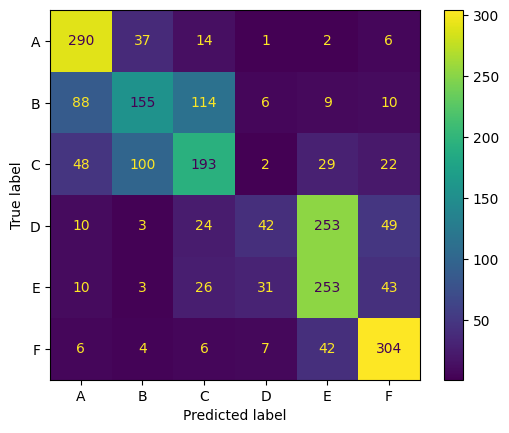

In [15]:
trainer.train()
report(trainer, tokenized_data['test'], labels, model_name)

In [16]:
clean_gpu_memory(transformer, tokenizer)

In [17]:
model_name = 'xlm-roberta-base'

transformer, tokenizer = import_model(model_name, labels, device)
tokenized_data = data.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir=f'models/{model_name}',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.2,
    num_train_epochs=3,
    logging_steps=100,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_total_limit=2,
    save_steps=100,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=transformer, 
    args=training_args, 
    train_dataset=tokenized_data['train'], 
    eval_dataset=tokenized_data['validation'],
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

Map:   0%|          | 0/17932 [00:00<?, ? examples/s]

Map:   0%|          | 0/2242 [00:00<?, ? examples/s]

Map:   0%|          | 0/2242 [00:00<?, ? examples/s]

/home/crimsowl/.cache/pypoetry/virtualenvs/nlp-project-7TuoKFiO-py3.11/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,1.798800,1.776294,0.160571
200,1.587700,1.698686,0.262266
300,1.443500,1.291309,0.421499
400,1.307200,1.222367,0.463872
500,1.266500,1.170979,0.473238
600,1.145400,1.357092,0.433988
700,1.073300,1.031386,0.530776
800,1.034200,1.010868,0.552632
900,1.026300,1.027245,0.530330
1000,0.974200,1.090978,0.515165


xlm-roberta-base
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       350
           1       0.53      0.48      0.51       382
           2       0.48      0.60      0.54       394
           3       0.53      0.36      0.43       381
           4       0.43      0.42      0.42       366
           5       0.68      0.87      0.76       369

    accuracy                           0.57      2242
   macro avg       0.57      0.57      0.57      2242
weighted avg       0.57      0.57      0.56      2242



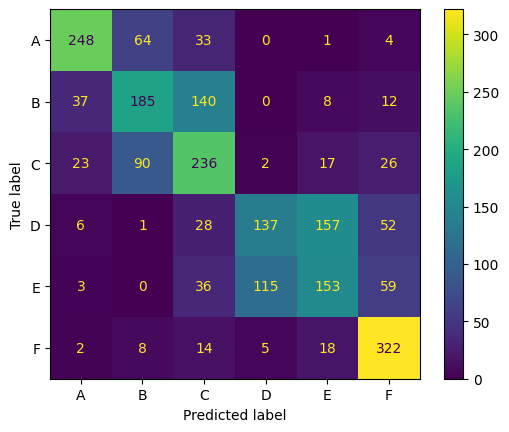

In [18]:
trainer.train()
report(trainer, tokenized_data['test'], labels, model_name)

In [ ]:
# This is text generated by ChatGPT when prompted:
# "Explain in a short sentence why the natural language processing field is cool"
sample_text = 'The natural language processing field is cool because it enables machines to understand, interpret, and generate human language, which has numerous real-world applications.' 
predict(sample_text)